# Training and evaluation pipeline
In this notebook we try the best feature sets based on previous feature selection and dimensonality reduction analysis in different classification models. We include cross validation and evaluate the models on different metrics.

In [ ]:
# evaluar varios clasificadores con diferentes subsets de características y métodos para reducir la dimensionalidad

- Models to try: SVM with different kernels, bayesian classifier, MLP?
- Feature sets: LDA, PCA, simple feature selection

Cargamos directamente el dataframe transformado (la ingeniería de características va fuera del pipeline)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # LDA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    make_scorer
)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.feature_selection import SequentialFeatureSelector  # NEW for sequential selection



data_path = 'transformed_df.csv'
target_column = 'y'



class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a subset of columns (features) from a pandas DataFrame.
    """
    def __init__(self, feature_names):
        """
        Parameters:
            feature_names (list): List of column names to select.
        """
        self.feature_names = feature_names

    def fit(self, X, y=None):
        # Validate that the provided feature names exist in X
        missing = [f for f in self.feature_names if f not in X.columns]
        if missing:
            raise ValueError("The following features are missing in the data: " + str(missing))
        return self

    def transform(self, X):
        return X[self.feature_names]




class TrainingPipeline:
    """
    A configurable training pipeline that loads data, preprocesses features (using either
    naive feature selection, sequential feature selection, or dimensionality reduction),
    trains a classifier using cross‑validation, and evaluates performance under multiple metrics.
    """
    def __init__(
        self,
        data_path,
        target_column,
        scaling=True,
        feature_selection_method=None,  # Options: 'naive' or 'sequential'
        feature_list=None,              # Required if feature_selection_method == 'naive'
        sfs_params=None,                # Required if feature_selection_method == 'sequential'
        reduction_method=None,          # Options: 'pca' or 'lda'
        reduction_params=None,
        classifier_name='gnb',          # Options: 'gnb' or 'svm'
        classifier_params=None,
        cv_splits=5,
        scoring_metrics=None,
        random_state=42
    ):
        """
        Parameters:
            data_path (str): Path to the CSV file.
            target_column (str): Name of the target column.
            scaling (bool): Whether to scale the data.
            feature_selection_method (str or None): If set, can be 'naive' for using a predefined
                feature list or 'sequential' to perform sequential feature selection.
            feature_list (list or None): List of feature names (required if feature_selection_method=='naive').
            sfs_params (dict or None): Parameters for SequentialFeatureSelector (required if
                feature_selection_method=='sequential'). For example:
                {'n_features_to_select': 5, 'direction': 'forward', 'cv': 3}
            reduction_method (str or None): Either 'pca' or 'lda' if you want to perform dimensionality
                reduction. Should be mutually exclusive with feature_selection_method.
            reduction_params (dict or None): Parameters to pass to the dimensionality reduction object.
            classifier_name (str): 'gnb' for GaussianNB or 'svm' for SVC.
            classifier_params (dict or None): Dictionary with classifier hyperparameters.
            cv_splits (int): Number of cross-validation splits.
            scoring_metrics (dict or None): Dictionary of scoring functions.
            random_state (int): Random seed.
        """
        self.data_path = data_path
        self.target_column = target_column
        self.scaling = scaling
        self.feature_selection_method = feature_selection_method
        self.feature_list = feature_list
        self.sfs_params = sfs_params or {}
        self.reduction_method = reduction_method
        self.reduction_params = reduction_params or {}
        self.classifier_name = classifier_name
        self.classifier_params = classifier_params or {}
        self.cv_splits = cv_splits
        # Default scoring: accuracy, precision, recall, and F1 (macro averaged)
        self.scoring_metrics = scoring_metrics or {
            'accuracy': 'accuracy',
            'precision': make_scorer(precision_score, average='weighted'),
            'recall': make_scorer(recall_score, average='weighted'),
            'f1': make_scorer(f1_score, average='weighted')
        }
        self.random_state = random_state

        self.pipeline = None  # This will hold the scikit-learn Pipeline
        self.data = None
        self.X = None
        self.y = None

    def load_data(self):
        """Loads data from the CSV file and splits it into features and target."""
        self.data = pd.read_csv(self.data_path)
        self.X = self.data.drop(columns=[self.target_column])
        self.y = self.data[self.target_column]

    def build_pipeline(self):
        """
        Constructs the scikit-learn Pipeline based on the configuration.

        The steps are chosen according to the following mutually exclusive options:
            - Naive feature selection (using a predefined feature list).
            - Sequential feature selection (using SequentialFeatureSelector).
            - Dimensionality reduction (using PCA or LDA).
            - (If none of the above are provided, only scaling is applied if enabled.)
        Followed by the classifier.
        """
        steps = []

        # Prevent mixing feature selection with dimensionality reduction in this pipeline.
        if self.feature_selection_method is not None and self.reduction_method is not None:
            raise ValueError("Cannot use both feature_selection_method and reduction_method simultaneously.")

        # CASE 1: Naive Feature Selection
        if self.feature_selection_method == 'naive':
            if not self.feature_list:
                raise ValueError("feature_list must be provided when using naive feature selection.")
            steps.append(('feature_selector', FeatureSelector(self.feature_list)))
            if self.scaling:
                steps.append(('scaler', StandardScaler()))

        # CASE 2: Sequential Feature Selection
        elif self.feature_selection_method == 'sequential':
            # For sequential feature selection, scaling is typically recommended first.
            if self.scaling:
                steps.append(('scaler', StandardScaler()))
            if not self.sfs_params:
                raise ValueError("sfs_params must be provided for sequential feature selection.")
            # Use a clone of the final classifier as the estimator for SFS.
            classifier_name = self.classifier_name.lower()
            if classifier_name == 'gnb':
                base_estimator = GaussianNB(**self.classifier_params)
            elif classifier_name == 'svm':
                base_estimator = SVC(**self.classifier_params)
            else:
                raise ValueError("Unsupported classifier for sequential feature selection: " + self.classifier_name)
            steps.append(('sequential_selector', SequentialFeatureSelector(base_estimator, **self.sfs_params)))

        # CASE 3: Dimensionality Reduction
        elif self.reduction_method is not None:
            if self.scaling:
                steps.append(('scaler', StandardScaler()))
            method = self.reduction_method.lower()
            if method == 'pca':
                steps.append(('pca', PCA(**self.reduction_params)))
            elif method == 'lda':
                steps.append(('lda', LinearDiscriminantAnalysis(**self.reduction_params)))
            else:
                raise ValueError("Unsupported reduction method: " + self.reduction_method)

        # CASE 4: No explicit feature selection or reduction (just scaling if enabled)
        else:
            if self.scaling:
                steps.append(('scaler', StandardScaler()))

        # Instantiate the final classifier
        classifier_name = self.classifier_name.lower()
        if classifier_name == 'gnb':
            classifier = GaussianNB(**self.classifier_params)
        elif classifier_name == 'svm':
            classifier = SVC(**self.classifier_params)
        else:
            raise ValueError("Unsupported classifier: " + self.classifier_name)
        steps.append(('classifier', classifier))

        self.pipeline = Pipeline(steps)
    
    def optimize_hyperparameters(self, param_grid, scoring='accuracy', n_jobs=-1):
        """
        Performs hyperparameter optimization using GridSearchCV on the built pipeline.

        Parameters:
            param_grid (dict): Dictionary defining the grid of parameters to search.
            scoring (str or callable): Scoring function to use.
            n_jobs (int): Number of jobs to run in parallel.

        Returns:
            grid_search (GridSearchCV): The fitted GridSearchCV instance.
        """
        # Ensure data is loaded and the pipeline is built.
        if self.data is None:
            self.load_data()
        if self.pipeline is None:
            self.build_pipeline()

        cv = StratifiedKFold(n_splits=self.cv_splits, shuffle=True, random_state=self.random_state)
        grid_search = GridSearchCV(
            self.pipeline,
            param_grid,
            cv=cv,
            scoring=scoring,
            n_jobs=n_jobs
        )
        grid_search.fit(self.X, self.y)
        print("Best parameters found:", grid_search.best_params_)
        print("Best cross-validation {}: {:.4f}".format(scoring, grid_search.best_score_))
        # Optionally, update the pipeline to the best estimator.
        self.pipeline = grid_search.best_estimator_
        return grid_search

    def evaluate_model(self):
        """
        Evaluates the pipeline using cross-validation.

        Returns:
            dict: Cross-validation results for each scoring metric.
        """
        cv = StratifiedKFold(n_splits=self.cv_splits, shuffle=True, random_state=self.random_state)
        results = cross_validate(
            self.pipeline,
            self.X,
            self.y,
            cv=cv,
            scoring=self.scoring_metrics,
            return_train_score=True,
            return_estimator=True
        )
        return results

    def run(self):
        """Runs the complete pipeline: loads data, builds the pipeline, and evaluates the model."""
        self.load_data()
        self.build_pipeline()
        results = self.evaluate_model()
        return results

In [68]:
config_pca = {
    'data_path': data_path,
    'target_column': target_column,
    'scaling': True,
    'feature_selection_method': None,     # No feature selection
    'feature_list': None,                   # Not needed here
    'reduction_method': 'pca',              # Use PCA (or 'lda' for LinearDiscriminantAnalysis)
    'reduction_params': {'n_components': 10},  # According to our research, some candidate good values might be between 7 and 10
    'classifier_name': 'svm',
    'classifier_params': {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'},
    'cv_splits': 5,
    'random_state': 42
}

pipeline_pca = TrainingPipeline(**config_pca)
results_pca = pipeline_pca.run()
print("\n=== PCA Dimensionality Reduction Results ===")
for key, value in results_pca.items():
    print(f"{key}: {np.mean(value):.4f} (+/- {np.std(value):.4f})")


=== PCA Dimensionality Reduction Results ===
fit_time: 0.3358 (+/- 0.0587)
score_time: 0.1263 (+/- 0.0056)
test_accuracy: 0.9786 (+/- 0.0028)
train_accuracy: 0.9815 (+/- 0.0008)
test_precision: 0.9785 (+/- 0.0027)
train_precision: 0.9814 (+/- 0.0008)
test_recall: 0.9786 (+/- 0.0028)
train_recall: 0.9815 (+/- 0.0008)
test_f1: 0.9785 (+/- 0.0027)
train_f1: 0.9814 (+/- 0.0008)


What results may be interesting?
- Model performance with different PCA dimensions (prove curse of dimensionality)
- LDA vs PCA
- Dimensionality reduction vs varios feature selection strategies
- Different models

In [ ]:
# a function that creates a dataframe that summarizes results

In [71]:
# Configuration for Naive Feature Selection
fisher_features = ['std',
 'var',
 'min',
 'max',
 'rms',
 'abs_max',
 'crest_factor',
 'margin_factor',
 'impulse_factor',
 'delta_power',
 'theta_power',
 'alpha_power',
 'beta_power',
 'gamma_power',
 'wavelet_energy_level_0',
 'wavelet_energy_level_1',
 'wavelet_energy_level_2',
 'wavelet_energy_level_3',
 'wavelet_energy_level_4',
 'approx_entropy']  # Features after filtering only with Fisher criterion

fisher_corr_features = ['std', 'crest_factor', 'margin_factor', 'delta_power', 'theta_power',
       'alpha_power', 'gamma_power', 'wavelet_energy_level_0',
       'wavelet_energy_level_1', 'wavelet_energy_level_2',
       'wavelet_energy_level_3', 'wavelet_energy_level_4', 'approx_entropy'] # Features after filtering with Fisher criterion + feature correlation

df = pd.DataFrame()

for feature_set,set_name in zip([fisher_features,fisher_corr_features],["Fisher","Fisher and Corr"]):
    
    config_naive = {
        'data_path': data_path,
        'target_column': target_column,
        'scaling': True,
        'feature_selection_method': 'naive',  # Use naive feature selection branch
        'feature_list': feature_set,
        'reduction_method': None,             # No dimensionality reduction
        'classifier_name': 'svm',             # Options: 'svm' or 'gnb'
        'classifier_params': {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'},
        'cv_splits': 5,
        'random_state': 42
    }

    pipeline_naive = TrainingPipeline(**config_naive)
    results_naive = pipeline_naive.run()

    print("=== Naive Feature Selection Results ===")
    for key, value in results_naive.items():
        print(f"{key}: {np.mean(value):.4f} (+/- {np.std(value):.4f})")
    results_naive["feature set"]=set_name

    df = pd.concat([df,pd.DataFrame(results_naive).drop(columns=["fit_time","score_time"])],axis=0)

=== Naive Feature Selection Results ===
fit_time: 0.2458 (+/- 0.0175)
score_time: 0.1439 (+/- 0.0052)
test_accuracy: 0.9781 (+/- 0.0022)
train_accuracy: 0.9797 (+/- 0.0005)
test_precision: 0.9780 (+/- 0.0022)
train_precision: 0.9796 (+/- 0.0006)
test_recall: 0.9781 (+/- 0.0022)
train_recall: 0.9797 (+/- 0.0005)
test_f1: 0.9780 (+/- 0.0022)
train_f1: 0.9796 (+/- 0.0006)
=== Naive Feature Selection Results ===
fit_time: 0.2523 (+/- 0.0049)
score_time: 0.1513 (+/- 0.0058)
test_accuracy: 0.9783 (+/- 0.0025)
train_accuracy: 0.9800 (+/- 0.0006)
test_precision: 0.9782 (+/- 0.0025)
train_precision: 0.9799 (+/- 0.0006)
test_recall: 0.9783 (+/- 0.0025)
train_recall: 0.9800 (+/- 0.0006)
test_f1: 0.9782 (+/- 0.0025)
train_f1: 0.9799 (+/- 0.0007)


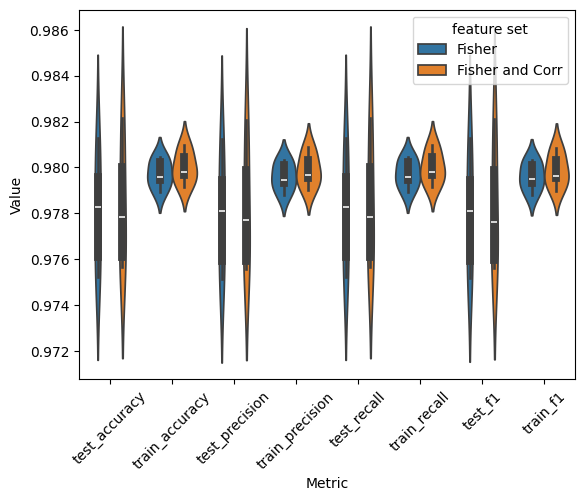

In [72]:
df_long = pd.melt(
    df, 
    id_vars=["feature set"],  
    var_name="Metric",        
    value_name="Value"        
)

sns.violinplot(data=df_long, x="Metric", y="Value", hue="feature set")
plt.xticks(rotation=45)
plt.show()


Model performance with different PCA components:

In [24]:
df = pd.DataFrame()

for pca_dim in range(2,25):
    
    config_pca = {
    'data_path': data_path,
    'target_column': target_column,
    'scaling': True,
    'feature_selection_method': None,     
    'feature_list': None,                   
    'reduction_method': 'pca',              
    'reduction_params': {'n_components': pca_dim}, 
    'classifier_name': 'svm',
    'classifier_params': {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'},
    'cv_splits': 5,
    'random_state': 42
    }

    pipeline_pca = TrainingPipeline(**config_pca)
    results_pca = pipeline_pca.run()

    print("=== PCA Results ===")
    for key, value in results_pca.items():
        if key == "estimator":
            continue
        print(f"{key}: {np.mean(value):.4f} (+/- {np.std(value):.4f})")
    results_pca["pca dimension"]=pca_dim

    df = pd.concat([df,pd.DataFrame(results_pca).drop(columns=["fit_time","score_time"])],axis=0)

=== PCA Results ===
fit_time: 0.3529 (+/- 0.0199)
score_time: 0.1390 (+/- 0.0205)
test_accuracy: 0.9645 (+/- 0.0015)
train_accuracy: 0.9658 (+/- 0.0006)
test_precision: 0.9642 (+/- 0.0014)
train_precision: 0.9655 (+/- 0.0006)
test_recall: 0.9645 (+/- 0.0015)
train_recall: 0.9658 (+/- 0.0006)
test_f1: 0.9643 (+/- 0.0014)
train_f1: 0.9656 (+/- 0.0006)
=== PCA Results ===
fit_time: 0.3246 (+/- 0.0169)
score_time: 0.1276 (+/- 0.0030)
test_accuracy: 0.9692 (+/- 0.0012)
train_accuracy: 0.9707 (+/- 0.0002)
test_precision: 0.9690 (+/- 0.0011)
train_precision: 0.9704 (+/- 0.0002)
test_recall: 0.9692 (+/- 0.0012)
train_recall: 0.9707 (+/- 0.0002)
test_f1: 0.9690 (+/- 0.0011)
train_f1: 0.9705 (+/- 0.0002)
=== PCA Results ===
fit_time: 0.3398 (+/- 0.0231)
score_time: 0.1266 (+/- 0.0024)
test_accuracy: 0.9705 (+/- 0.0017)
train_accuracy: 0.9719 (+/- 0.0004)
test_precision: 0.9704 (+/- 0.0016)
train_precision: 0.9717 (+/- 0.0004)
test_recall: 0.9705 (+/- 0.0017)
train_recall: 0.9719 (+/- 0.0004)
tes

<Axes: xlabel='pca dimension', ylabel='test_f1'>

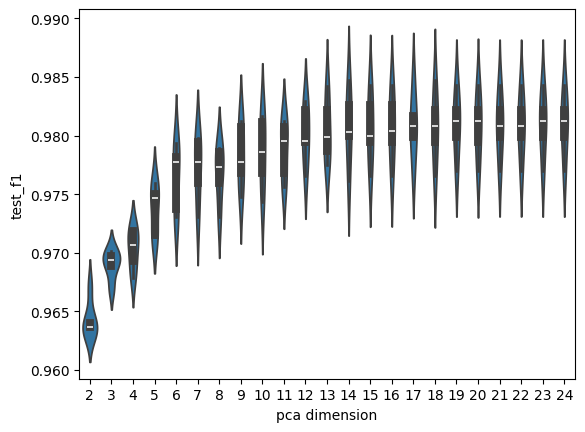

In [25]:
sns.violinplot(df, y="test_f1",x="pca dimension")

LDA vs best PCA in Bayes Classifier:

In [75]:
config_pca = {
    'data_path': data_path,
    'target_column': target_column,
    'scaling': True,
    'feature_selection_method': None,     
    'feature_list': None,                   
    'reduction_method': 'pca',              
    'reduction_params': {'n_components': 7}, 
    'classifier_name': 'svm',
    'classifier_params': {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'},    'cv_splits': 5,
    'random_state': 42
    }

pipeline_pca = TrainingPipeline(**config_pca)
results_pca = pipeline_pca.run()
results_pca["reduce method"] = "PCA"

config_lda = {
    'data_path': data_path,
    'target_column': target_column,
    'scaling': True,
    'feature_selection_method': None,     
    'feature_list': None,                   
    'reduction_method': 'lda',              
    'reduction_params': {'n_components': 1}, 
    'classifier_name': 'svm',
    'classifier_params': {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'},
    'cv_splits': 5,
    'random_state': 42
    }

pipeline_lda = TrainingPipeline(**config_lda)
results_lda = pipeline_lda.run()
results_lda["reduce method"] = "LDA"

In [76]:
df = pd.concat([pd.DataFrame(results_lda),pd.DataFrame(results_pca)], axis=0)
df.drop(columns=["fit_time","score_time"],inplace=True)

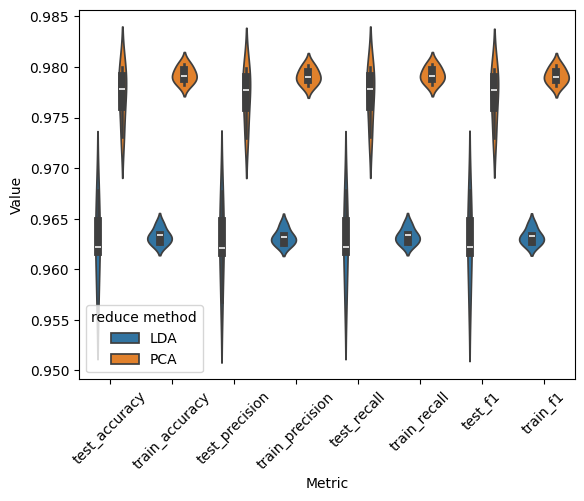

In [77]:
df_long = pd.melt(
    df, 
    id_vars=["reduce method"],  
    var_name="Metric",        
    value_name="Value"        
)

sns.violinplot(data=df_long, x="Metric", y="Value", hue="reduce method")
plt.xticks(rotation=45)
plt.show()

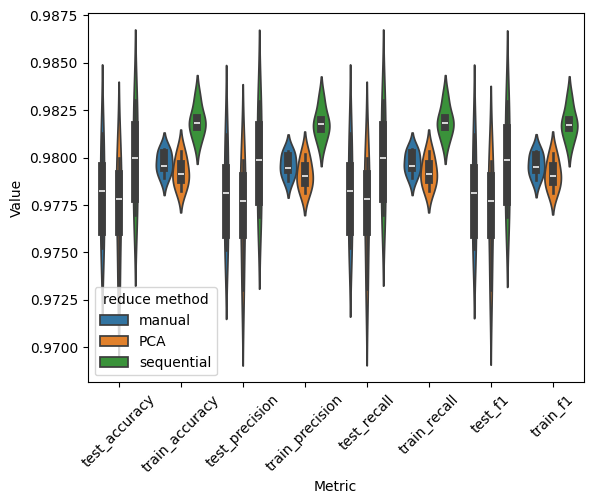

In [ ]:
# best pca vs best manual feature set

# NAIVE FEATURE SELECTION
config_naive = {
    'data_path': data_path,
    'target_column': target_column,
    'scaling': True,
    'feature_selection_method': 'naive', 
    'feature_list': fisher_features,
    'reduction_method': None,             
    'classifier_name': 'svm',             
    'classifier_params': {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'},
    'cv_splits': 5,
    'random_state': 42
}

pipeline_naive = TrainingPipeline(**config_naive)
results_naive = pipeline_naive.run()

results_naive["reduce method"] = "manual"




# Configuration for Sequential Feature Selection


# sfs_parameters = {
#     'n_features_to_select': 5,
#     'direction': 'forward',
#     'cv': 3,
#     'n_jobs': -1  # Use all processors; optional
# }

# config_sfs = {
#     'data_path': data_path,
#     'target_column': target_column,
#     'scaling': True,
#     'feature_selection_method': 'sequential',  # Use sequential feature selection branch
#     'feature_list': None,                      # Not needed here
#     'sfs_params': sfs_parameters,              # Parameters for SequentialFeatureSelector
#     'reduction_method': None,                  # No dimensionality reduction
#     'classifier_name': 'svm',
#     'classifier_params': {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'},
#     'cv_splits': 5,
#     'random_state': 42
# }

# pipeline_sfs = TrainingPipeline(**config_sfs)
# results_sfs = pipeline_sfs.run()

results_sfs["reduce method"] = "sequential"


df = pd.concat([pd.DataFrame(results_naive),pd.DataFrame(results_pca), pd.DataFrame(results_sfs)], axis=0)
df.drop(columns=["fit_time","score_time"],inplace=True)

df_long = pd.melt(
    df, 
    id_vars=["reduce method"],  
    var_name="Metric",        
    value_name="Value"        
)

sns.violinplot(data=df_long, x="Metric", y="Value", hue="reduce method")
plt.xticks(rotation=45)
plt.show()

In [19]:
# Qué feature set utiliza el sequential???

sfs_parameters = {
    'n_features_to_select': "auto",
    'direction': 'forward',
    'cv': 4,
    'n_jobs': -1
}

config_sfs = {
    'data_path': data_path,
    'target_column': target_column,
    'scaling': True,
    'feature_selection_method': 'sequential',  # Use sequential feature selection branch
    'feature_list': None,                      # Not needed here
    'sfs_params': sfs_parameters,              # Parameters for SequentialFeatureSelector
    'reduction_method': None,                  # No dimensionality reduction
    'classifier_name': 'svm',
    'classifier_params': {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'},
    'cv_splits': 5,
    'random_state': 42
}

pipeline_sfs = TrainingPipeline(**config_sfs)
results_sfs = pipeline_sfs.run()

In [22]:
features = pd.read_csv("transformed_df.csv").drop(columns="y").columns

for pipeline in results_sfs["estimator"]:
    print(features[pipeline.named_steps["sequential_selector"].get_support()].values)

['min' 'skew' 'zero_crossings' 'abs_max' 'margin_factor' 'shape_factor'
 'theta_power' 'alpha_power' 'wavelet_energy_level_0'
 'wavelet_energy_level_2' 'wavelet_energy_level_4' 'approx_entropy']
['std' 'min' 'skew' 'zero_crossings' 'impulse_factor' 'delta_power'
 'theta_power' 'alpha_power' 'beta_power' 'gamma_power'
 'wavelet_energy_level_1' 'approx_entropy']
['mean' 'std' 'skew' 'zero_crossings' 'margin_factor' 'delta_power'
 'theta_power' 'alpha_power' 'gamma_power' 'wavelet_energy_level_1'
 'wavelet_energy_level_3' 'approx_entropy']
['std' 'min' 'max' 'skew' 'zero_crossings' 'margin_factor'
 'impulse_factor' 'delta_power' 'theta_power' 'alpha_power' 'beta_power'
 'approx_entropy']
['mean' 'std' 'max' 'skew' 'rms' 'zero_crossings' 'impulse_factor'
 'delta_power' 'theta_power' 'alpha_power' 'wavelet_energy_level_2'
 'approx_entropy']


C:\Users\rjvil\AppData\Local\Temp\ipykernel_12824\3007504566.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_counts_df, x='count', y='feature', palette='viridis')


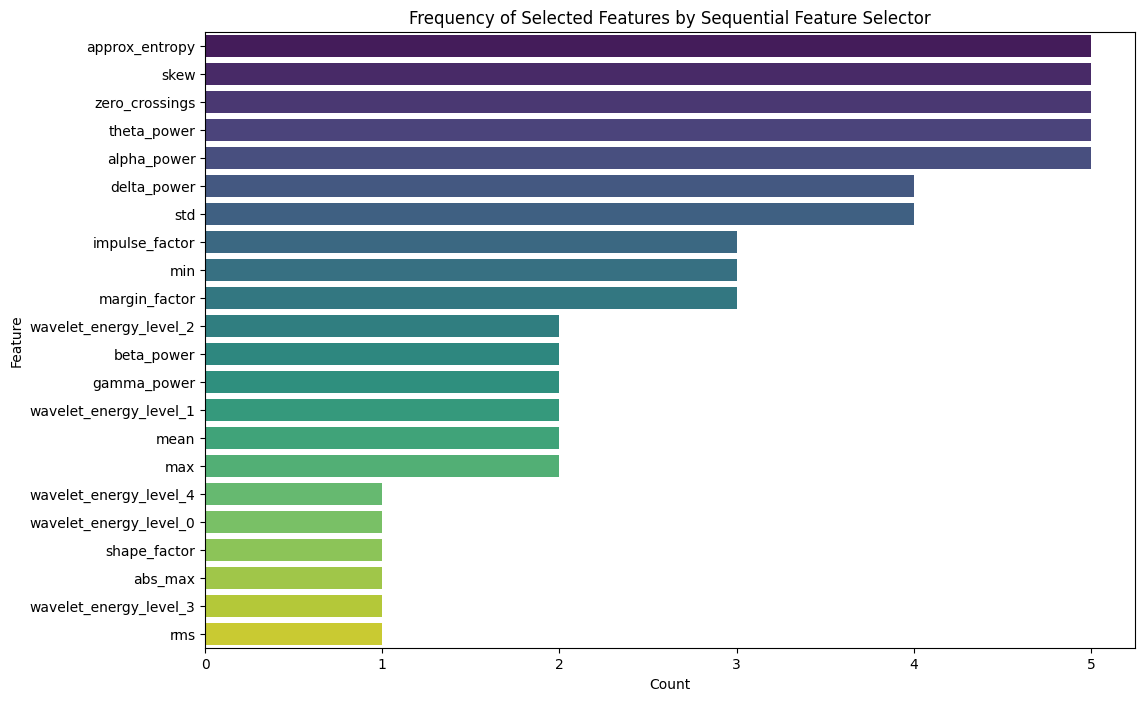

In [27]:
from collections import Counter
selected_features = []
for pipeline in results_sfs["estimator"]:
    selected_features.extend(features[pipeline.named_steps["sequential_selector"].get_support()].values)

feature_counts = Counter(selected_features)

feature_counts_df = pd.DataFrame.from_dict(feature_counts, orient='index', columns=['count']).reset_index()
feature_counts_df.rename(columns={'index': 'feature'}, inplace=True)
feature_counts_df.sort_values(by='count', ascending=False, inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_counts_df, x='count', y='feature', palette='viridis')
plt.title('Frequency of Selected Features by Sequential Feature Selector')
plt.xlabel('Count')
plt.ylabel('Feature')
plt.show()

In [29]:
# Y hacia atrás qué features le gustan?

# Qué feature set utiliza el sequential???

sfs_parameters = {
    'n_features_to_select': "auto",
    'direction': 'backward',
    'cv': 4,
    'n_jobs': -1
}

config_sfs = {
    'data_path': data_path,
    'target_column': target_column,
    'scaling': True,
    'feature_selection_method': 'sequential',  # Use sequential feature selection branch
    'feature_list': None,                      # Not needed here
    'sfs_params': sfs_parameters,              # Parameters for SequentialFeatureSelector
    'reduction_method': None,                  # No dimensionality reduction
    'classifier_name': 'svm',
    'classifier_params': {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'},
    'cv_splits': 5,
    'random_state': 42
}

pipeline_sfs = TrainingPipeline(**config_sfs)
results_sfs = pipeline_sfs.run()


In [30]:
features = pd.read_csv("transformed_df.csv").drop(columns="y").columns

for pipeline in results_sfs["estimator"]:
    print(features[pipeline.named_steps["sequential_selector"].get_support()].values)

['std' 'max' 'skew' 'rms' 'zero_crossings' 'abs_max' 'margin_factor'
 'shape_factor' 'delta_power' 'theta_power' 'alpha_power' 'gamma_power'
 'approx_entropy']
['mean' 'skew' 'kurtosis' 'zero_crossings' 'abs_max' 'margin_factor'
 'shape_factor' 'theta_power' 'alpha_power' 'gamma_power'
 'wavelet_energy_level_1' 'wavelet_energy_level_4' 'approx_entropy']
['mean' 'skew' 'kurtosis' 'rms' 'zero_crossings' 'abs_max' 'margin_factor'
 'shape_factor' 'theta_power' 'alpha_power' 'gamma_power'
 'wavelet_energy_level_4' 'approx_entropy']
['std' 'min' 'max' 'skew' 'rms' 'zero_crossings' 'margin_factor'
 'shape_factor' 'delta_power' 'theta_power' 'alpha_power'
 'wavelet_energy_level_1' 'approx_entropy']
['mean' 'min' 'skew' 'kurtosis' 'rms' 'zero_crossings' 'margin_factor'
 'delta_power' 'theta_power' 'alpha_power' 'wavelet_energy_level_1'
 'wavelet_energy_level_3' 'approx_entropy']


C:\Users\rjvil\AppData\Local\Temp\ipykernel_12824\3007504566.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_counts_df, x='count', y='feature', palette='viridis')


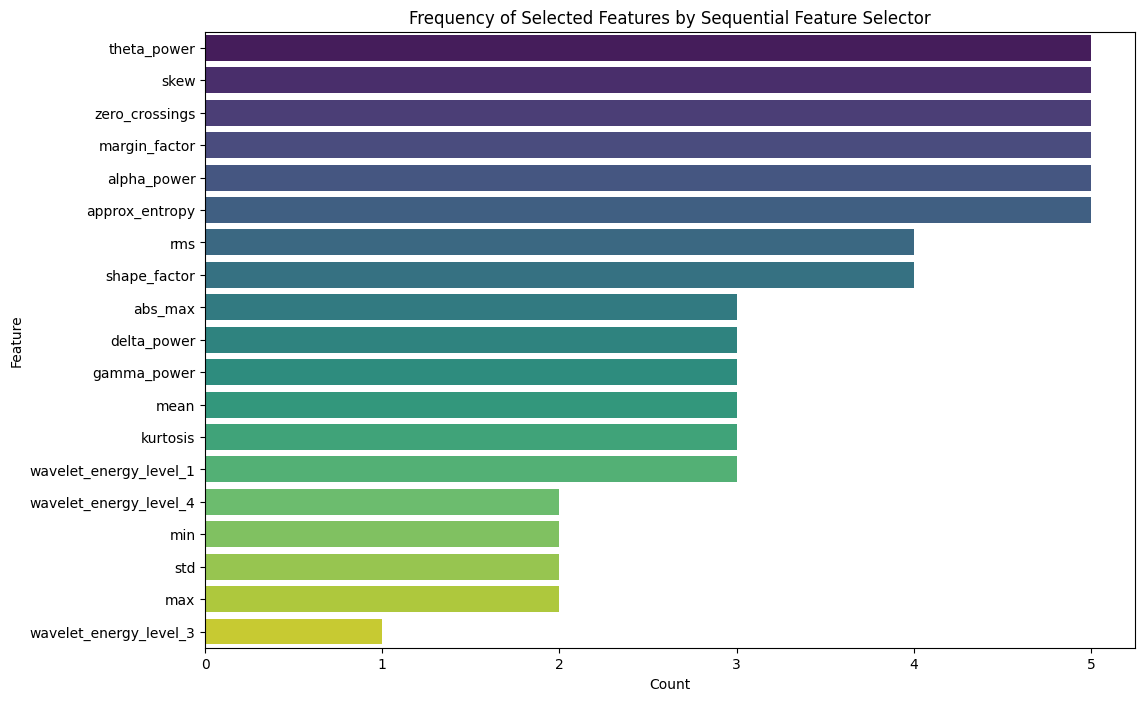

In [31]:
from collections import Counter
selected_features = []
for pipeline in results_sfs["estimator"]:
    selected_features.extend(features[pipeline.named_steps["sequential_selector"].get_support()].values)

feature_counts = Counter(selected_features)

feature_counts_df = pd.DataFrame.from_dict(feature_counts, orient='index', columns=['count']).reset_index()
feature_counts_df.rename(columns={'index': 'feature'}, inplace=True)
feature_counts_df.sort_values(by='count', ascending=False, inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_counts_df, x='count', y='feature', palette='viridis')
plt.title('Frequency of Selected Features by Sequential Feature Selector')
plt.xlabel('Count')
plt.ylabel('Feature')
plt.show()

Seems like backward selection algorithm yields similar results. Maybe contrast with feature importance.

In [79]:
def run_pipeline(config):
    pipeline = TrainingPipeline(**config)
    results = pipeline.run()
    return results


config_bayes = {
    'data_path': data_path,
    'target_column': target_column,
    'scaling': True,
    'feature_selection_method': None,
    'feature_list': None,
    'reduction_method': 'pca',
    'reduction_params': {'n_components': 7},
    'classifier_name': 'gnb',
    'classifier_params': {},
    'cv_splits': 5,
    'random_state': 42
}


config_svm_rbf = config_pca.copy()
config_svm_rbf['classifier_name'] = 'svm'
config_svm_rbf['classifier_params'] = {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'}

config_svm_linear = config_pca.copy()
config_svm_linear['classifier_name'] = 'svm'
config_svm_linear['classifier_params'] = {'kernel': 'linear', 'C': 1.0}

config_svm_poly = config_pca.copy()
config_svm_poly['classifier_name'] = 'svm'
config_svm_poly['classifier_params'] = {'kernel': 'poly', 'C': 1.0, 'degree': 3}



results_bayes = run_pipeline(config_bayes)
results_bayes["classifier"] = "Bayes"

results_svm_rbf = run_pipeline(config_svm_rbf)
results_svm_rbf["classifier"] = "SVM RBF"

results_svm_linear = run_pipeline(config_svm_linear)
results_svm_linear["classifier"] = "SVM Linear"

results_svm_poly = run_pipeline(config_svm_poly)
results_svm_poly["classifier"] = "SVM Poly"



df = pd.concat([pd.DataFrame(results_bayes), pd.DataFrame(results_svm_rbf), pd.DataFrame(results_svm_linear), pd.DataFrame(results_svm_poly)], axis=0)
df.drop(columns=["fit_time","score_time"], inplace=True)


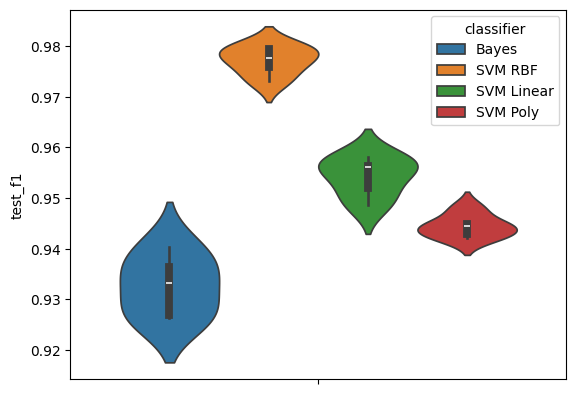

In [80]:
sns.violinplot(data=df, y="test_f1", hue="classifier")
plt.xticks(rotation=45)
plt.show()